<div >
<img src = "figures_notebook/banner.png" />
</div>

# CARTs,Forests and Boosting

## Predicción de los precios de la vivienda

Nuestro objetivo hoy es construir un modelo para predecir los precios de la vivienda. Del artículo histórico de Rosen "Hedonic Prices and Implicit Markets: Product Differentiation in Pure Competition" (1974), sabemos que un vector de sus características describe un bien diferenciado.

En el caso de una casa, estas características pueden incluir atributos estructurales (por ejemplo, número de dormitorios), amenidades, etc.. Así, podemos escribir el precio de mercado de la casa como:

$$
Price=f(atributos\,estructurales,amenidades,...)
$$


Sin embargo, la teoría de Rosen no nos dice mucho sobre la forma funcional de $f$.

## CARTS: Example

Cargamos los paquetes

In [1]:
#packages
require("pacman")
p_load("tidyverse","ggplot2")

Loading required package: pacman



##### With Ames Data Set

Vamos a usar `rpart`

In [2]:
p_load("rpart")

In [3]:
p_load("modeldata")

data("ames", package = "modeldata")

ames<-ames  %>% filter(Neighborhood %in%c("North_Ames", "College_Creek", "Old_Town", "Edwards", "Somerset", "Northridge_Heights", "Gilbert", "Sawyer", "Northwest_Ames", "Sawyer_West"))


In [4]:
head(ames)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


The description of the variables can be viewed here: https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [5]:
class(ames$Fence)

[1] "factor"

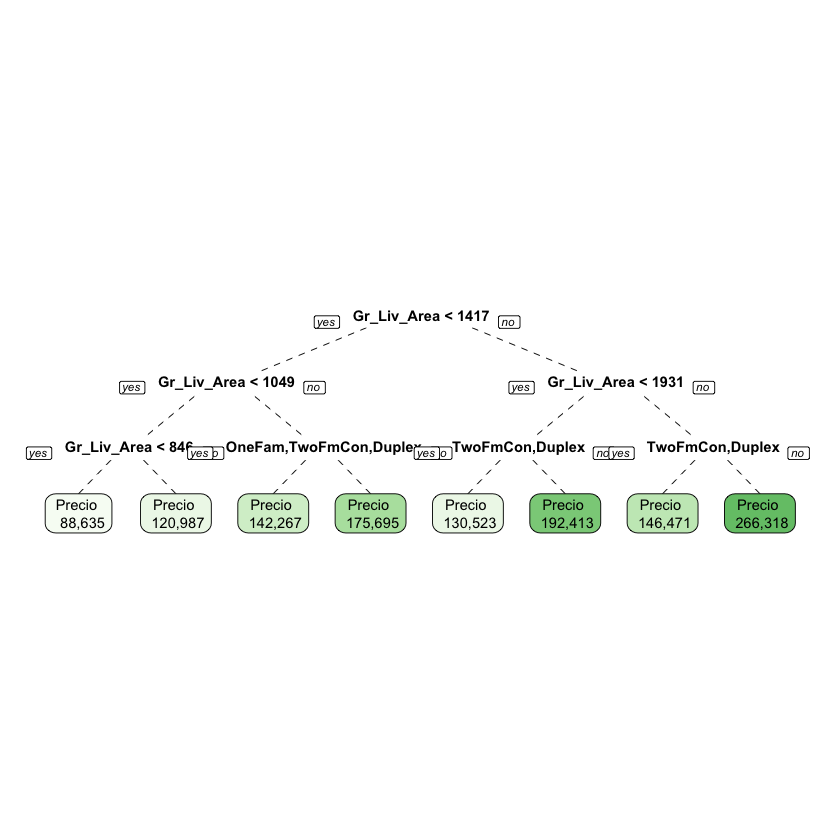

In [6]:
amestree<-rpart(log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,data=ames, control = list(maxdepth = 3))

p_load("rpart.plot")
prp(amestree, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(amestree$frame$yval), 0), nsmall=0, big.mark=",")))

### Sobreajuste

In [7]:
amestree<-rpart(log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,data=ames,cp=-1)

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


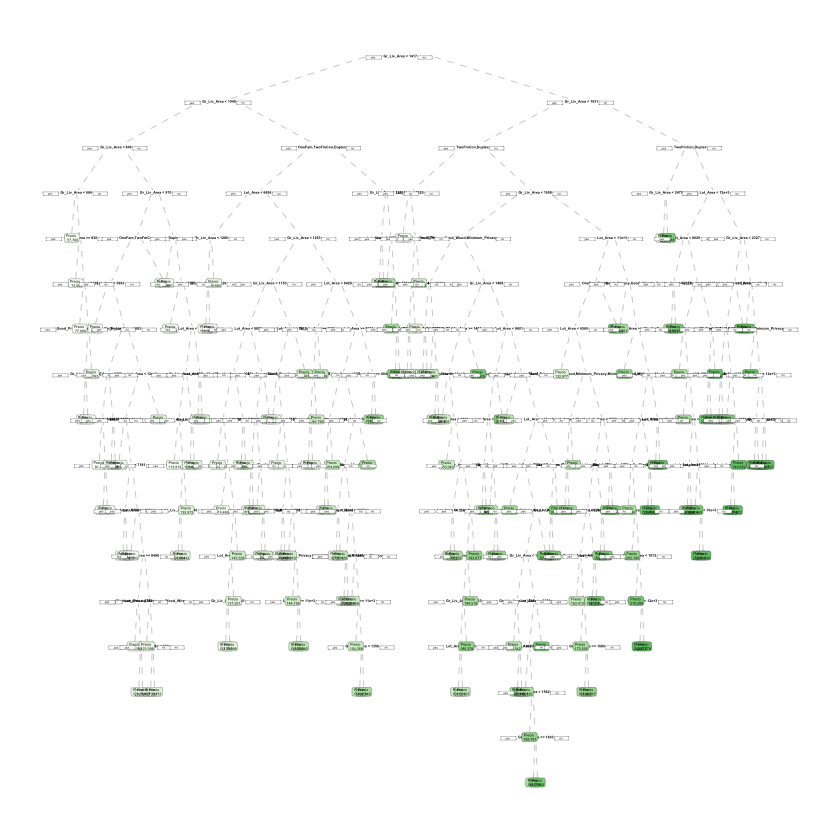

In [8]:
p_load("rpart.plot")
prp(amestree, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(amestree$frame$yval), 0), nsmall=0, big.mark=",")))


- Fijar la profundidad del árbol. (implementado en Caret `method=rpart2`)

- Fijar la mínima cantidad de datos que están contenidos dentro de cada hoja. 

- Cost complexity pruning (implementado en Caret con `method=rpart`)

`tidymodels` implementa todos

##### Implementación con Caret

In [9]:
p_load("caret")

In [10]:
fitControl<-trainControl(method ="cv",
                         number=5)

#####  `method=rpart2`  allows to tune Max Tree Depth

In [11]:
set.seed(123)
tree_rpart2 <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames,
    method = "rpart2",
    trControl = fitControl,
    tuneGrid = expand.grid(maxdepth = seq(1,30,1))
)

In [12]:
tree_rpart2

CART 

2063 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1651, 1651, 1650, 1651, 1649 
Resampling results across tuning parameters:

  maxdepth  RMSE       Rsquared   MAE      
   1        0.3076130  0.3221351  0.2299792
   2        0.2920483  0.3896141  0.2152181
   3        0.2832392  0.4266327  0.2095505
   4        0.2790818  0.4431936  0.2081170
   5        0.2740480  0.4630493  0.2036835
   6        0.2697981  0.4801112  0.2008007
   7        0.2673430  0.4891130  0.1988199
   8        0.2670243  0.4906269  0.1984846
   9        0.2670880  0.4907169  0.1984789
  10        0.2670880  0.4907169  0.1984789
  11        0.2670880  0.4907169  0.1984789
  12        0.2670880  0.4907169  0.1984789
  13        0.2670880  0.4907169  0.1984789
  14        0.2670880  0.4907169  0.1984789
  15        0.2670880  0.4907169  0.1984789
  16        0.2670880  0.4907169  0.1984789
  17        0.2670880  0.4907169  0.1984789
  18        0.2

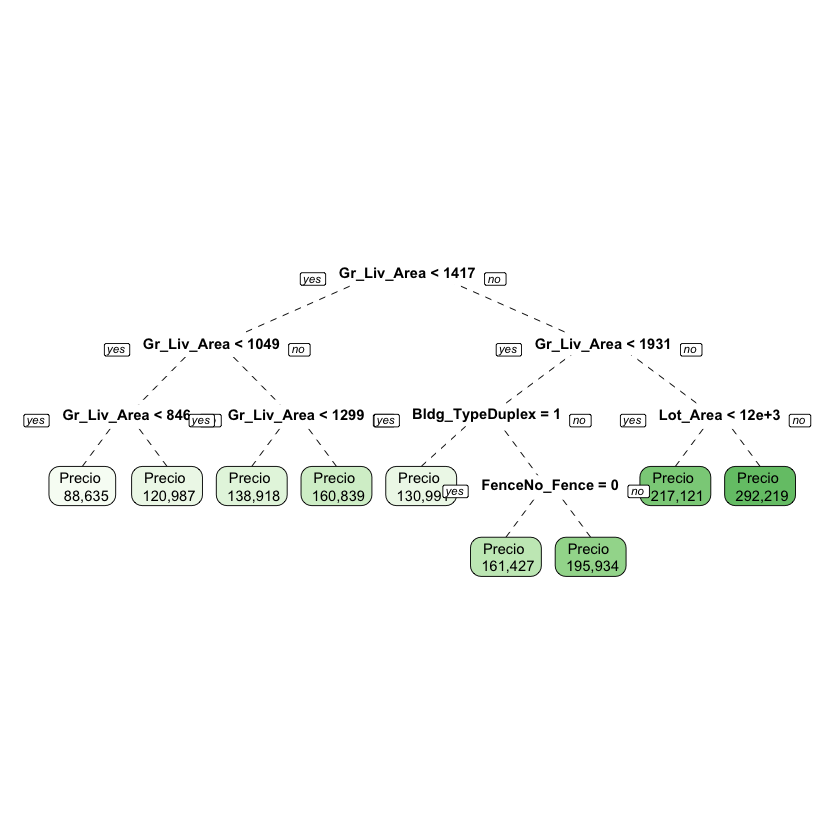

In [13]:
prp(tree_rpart2$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_rpart2$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

#### Cost complexity Prunning


Cost complexity del árbol  $T$ con $[T]$ nodos terminales del árbol 
\begin{align}
  C_{\alpha}(T)= \sum_{m=1}^{[T]}  \sum_{x_i\in R_m} (y_i-\hat{y}_m)^2 + \alpha [T]
\end{align}


Objetivo: para un dado $\alpha$, encontrar el pruning óptimo que minimice  $C_{\alpha}(T)$

Se logra eliminando sucesivamente las ramas que producen un aumento mínimo en $\sum_{x_i\in R_m} (y_i-\hat{y}_m)^2 $


##### Algoritmo completo

  - Hacemos crecer el árbol

  - Para un dado $\alpha$, aplicamos  *cost complexity pruning* 
    
  - Utilizamos K-fold cross-validation para elegir $\alpha$. 

  
Tenemos entonces una secuencia de subarboles para distintos valores de $\alpha$ 

Elegimos el $\alpha$ y el subárbol que tienen el menor error de predicción.

#####  `method=rpart`  only allows to tune Complexity Parameter

- Can change the length


In [14]:
set.seed(123)
tree_lenght <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames,
    method = "rpart",
    metric="MAE",
    trControl = fitControl,
    tuneLength=100
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


In [15]:
tree_lenght

CART 

2063 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1651, 1651, 1650, 1651, 1649 
Resampling results across tuning parameters:

  cp            RMSE       Rsquared   MAE      
  0.0001829893  0.2597482  0.5279496  0.1901113
  0.0001835106  0.2597482  0.5279496  0.1901113
  0.0002043565  0.2598933  0.5273574  0.1901204
  0.0002129807  0.2599535  0.5271216  0.1900896
  0.0002147647  0.2599535  0.5271216  0.1900896
  0.0002179573  0.2598733  0.5274092  0.1899765
  0.0002586037  0.2596582  0.5279250  0.1899910
  0.0002918794  0.2595264  0.5284919  0.1900346
  0.0003021826  0.2594587  0.5287884  0.1899449
  0.0003100108  0.2594441  0.5288437  0.1898085
  0.0003117163  0.2595105  0.5286103  0.1898569
  0.0003127046  0.2595105  0.5286103  0.1898569
  0.0003135710  0.2594809  0.5287295  0.1897946
  0.0003176683  0.2594048  0.5289767  0.1896716
  0.0003177627  0.2594048  0.5289767  0.1896716
  0.0003249438  0.2593189  0.5292462  0

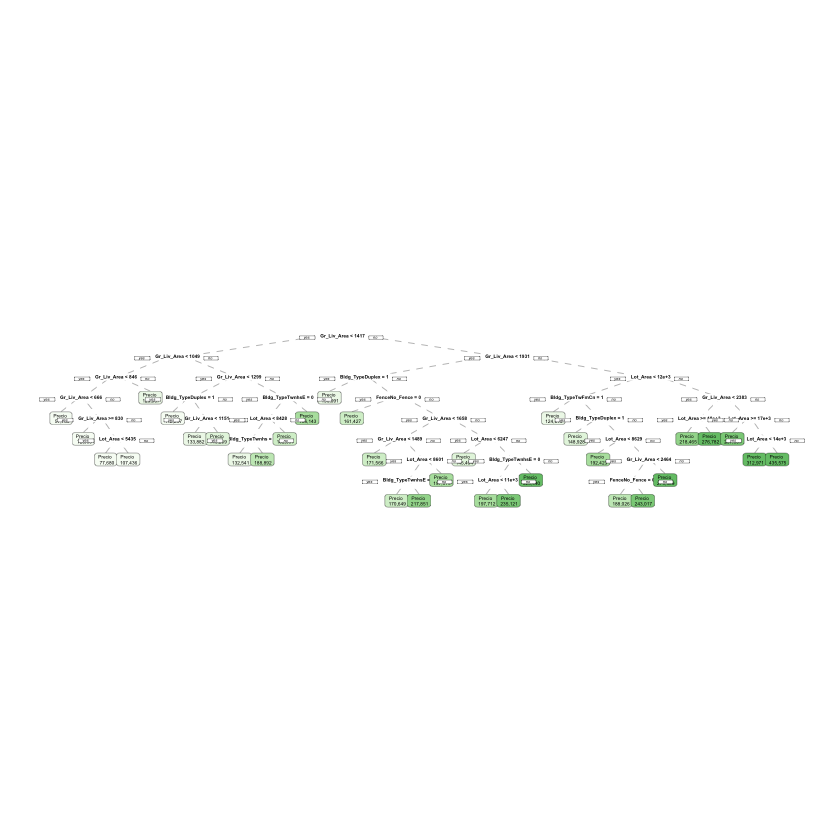

In [16]:
prp(tree_lenght$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_lenght$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

- Or the grid

In [17]:
set.seed(123)
tree_grid <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames,
    method = "rpart",
    trControl = fitControl,
    tuneGrid = expand.grid(cp = seq(0.001707763, 0.001707765, length.out = 100))
)


In [18]:
tree_grid

CART 

2063 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1651, 1651, 1650, 1651, 1649 
Resampling results across tuning parameters:

  cp           RMSE       Rsquared  MAE     
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.182453
  0.001707763  0.2513605  0.55202   0.1824

More details here: https://topepo.github.io/caret/train-models-by-tag.html#tree-based-model

### Comentarios sobre Árboles


#### Pros: 
  
    - Los árboles son muy fáciles de explicar a las personas (probablemente incluso más fáciles que la regresión lineal)

    - Los árboles se pueden trazar gráficamente y son fácilmente interpretados incluso por no expertos. Variables más importantes en la parte superior



#### Cons:
    
    - Si la estructura es lineal, CART no funciona bien
    
<div >
<img src = "figures_notebook/tree_vs_reg.png" />
</div>


    - Los árboles no son muy robustos 
    

In [19]:
set.seed(123)
tree_rpart2_rob <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames[-c(1:20),],
    method = "rpart2",
    trControl = fitControl,
    tuneGrid = expand.grid(maxdepth = seq(1,30,1))
)

In [20]:
tree_rpart2_rob

CART 

2043 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1634, 1636, 1633, 1635, 1634 
Resampling results across tuning parameters:

  maxdepth  RMSE       Rsquared   MAE      
   1        0.3093770  0.3188655  0.2317362
   2        0.2936029  0.3872337  0.2172230
   3        0.2836288  0.4292888  0.2100289
   4        0.2804283  0.4416750  0.2071989
   5        0.2754844  0.4617727  0.2049167
   6        0.2720396  0.4746310  0.2022798
   7        0.2703747  0.4814416  0.2004039
   8        0.2685697  0.4885841  0.1984887
   9        0.2684559  0.4889455  0.1982535
  10        0.2684559  0.4889455  0.1982535
  11        0.2684559  0.4889455  0.1982535
  12        0.2684559  0.4889455  0.1982535
  13        0.2684559  0.4889455  0.1982535
  14        0.2684559  0.4889455  0.1982535
  15        0.2684559  0.4889455  0.1982535
  16        0.2684559  0.4889455  0.1982535
  17        0.2684559  0.4889455  0.1982535
  18        0.2

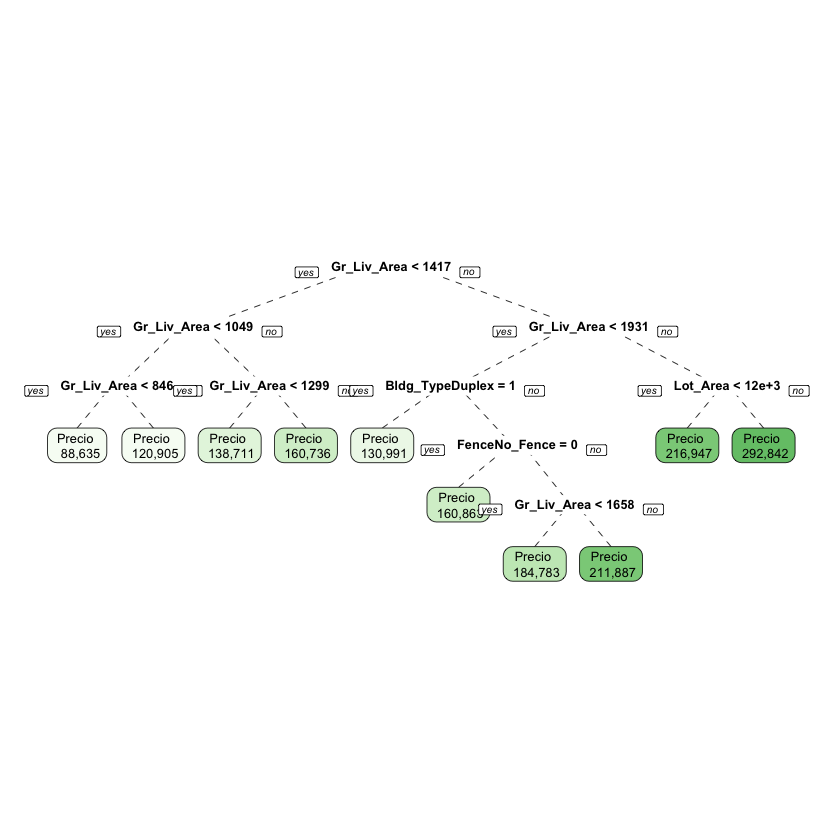

In [21]:
prp(tree_rpart2_rob$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_rpart2_rob$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

#### Cambios en la muestra

In [22]:
db_sample<- sample_frac(ames,size=1,replace=TRUE) #takes a sample with replacement of the same size of the original sample (1 or 100%)

In [23]:
set.seed(123)
tree_rpart2_rob_sample <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=db_sample,
    method = "rpart2",
    trControl = fitControl,
    tuneGrid = expand.grid(maxdepth = seq(1,30,1))
)

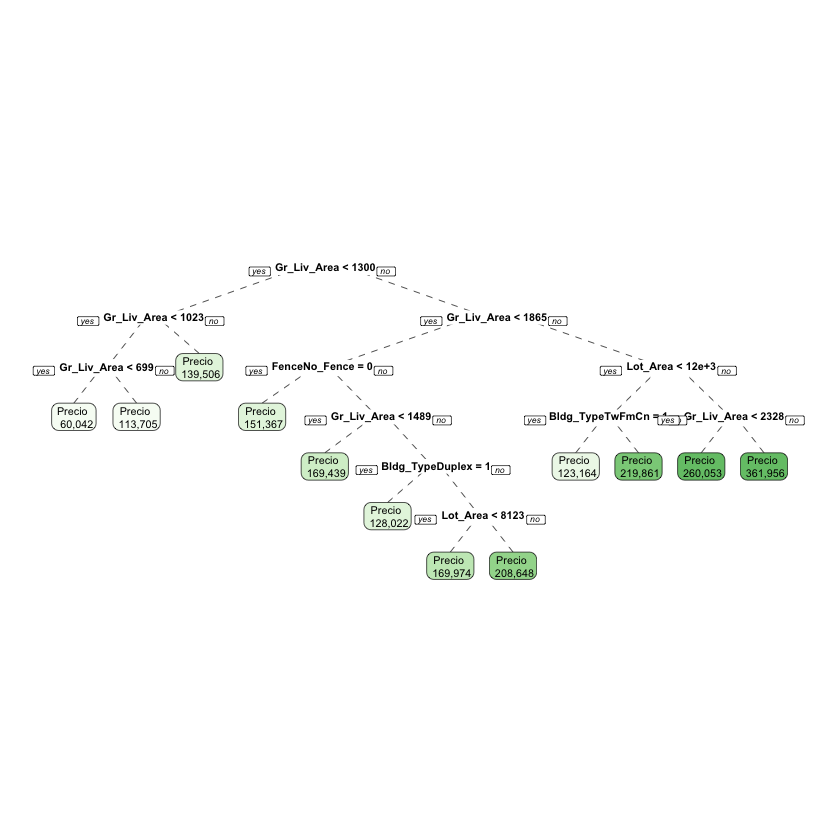

In [24]:
prp(tree_rpart2_rob_sample$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_rpart2_rob_sample$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

## Random Forests

Vamos a usar `ranger: A Fast Implementation of Random Forests`

In [25]:
p_load("ranger")

In [26]:
set.seed(123)

tree_ranger <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence,
    data=ames,
    method = "ranger",
    trControl = fitControl,
    tuneGrid=expand.grid(
              mtry = 1,
              splitrule = "variance",
              min.node.size = 5)
)

In [27]:
tree_ranger

Random Forest 

2063 samples
   3 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1651, 1651, 1650, 1651, 1649 
Resampling results:

  RMSE       Rsquared   MAE      
  0.3177917  0.4601896  0.2323413

Tuning parameter 'mtry' was held constant at a value of 1
Tuning
 parameter 'splitrule' was held constant at a value of variance

Tuning parameter 'min.node.size' was held constant at a value of 5

### Hiperparámetros

    - mtry (#Randomly Selected Predictors)
    - splitrule (Splitting Rule)
    - min.node.size (Minimal Node Size)



In [28]:
set.seed(123)

tree_ranger_grid <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence,
    data=ames,
    method = "ranger",
    trControl = fitControl,
    tuneGrid=expand.grid(
              mtry = c(1,2,3),
              splitrule = "variance",
              min.node.size = c(5,10,15))
)

In [29]:
tree_ranger_grid

Random Forest 

2063 samples
   3 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1651, 1651, 1650, 1651, 1649 
Resampling results across tuning parameters:

  mtry  min.node.size  RMSE       Rsquared   MAE      
  1      5             0.3169043  0.4633973  0.2316323
  1     10             0.3187282  0.4558531  0.2332558
  1     15             0.3192152  0.4574563  0.2337218
  2      5             0.2718699  0.5459319  0.1948974
  2     10             0.2716431  0.5461592  0.1949878
  2     15             0.2723888  0.5450137  0.1953341
  3      5             0.2494286  0.5782360  0.1786118
  3     10             0.2495220  0.5776118  0.1787281
  3     15             0.2493990  0.5779976  0.1786248

Tuning parameter 'splitrule' was held constant at a value of variance
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 3, splitrule = variance
 and min.node.size = 15.

## Boosting Trees

In [30]:
db<-read.csv("https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/boosting_tree_toy.csv")
head(db)

y<-db$y
x<-db$x

,X,x,y
,<int>,<dbl>,<dbl>
1,1,0.08216883,0.19462317
2,2,0.08413394,0.07939476
3,3,0.14659427,0.06655269
4,4,0.17459164,-0.05863454
5,5,0.22330805,-0.15040834
6,6,0.29192236,0.01899571


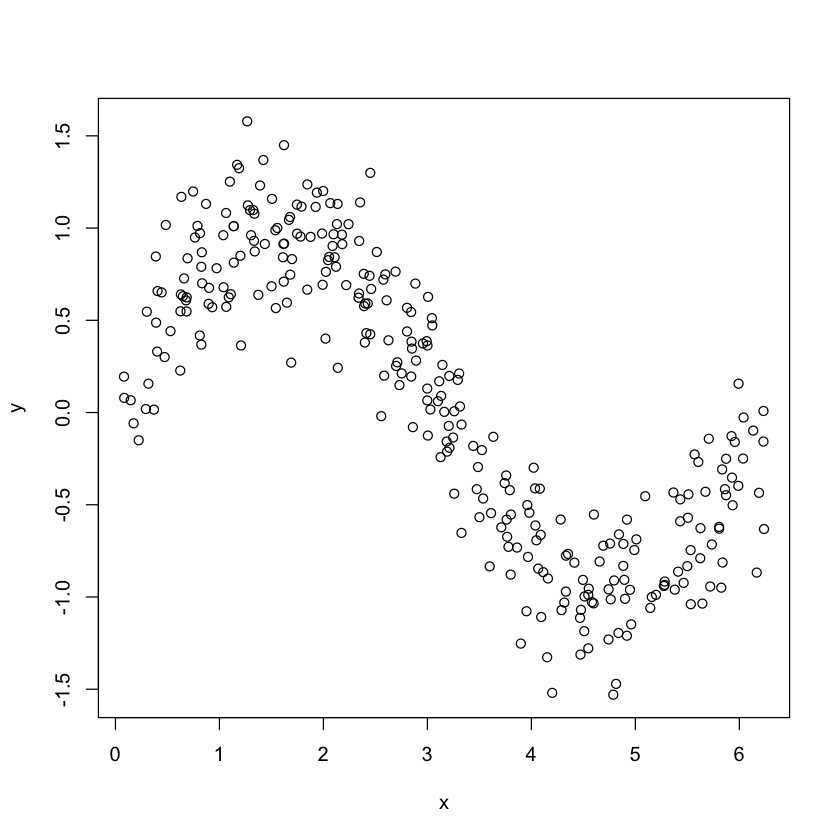

In [31]:
plot(x,y)

### Hiperparámetros

- $\lambda$ la tasa a la que aprende, los valores típicos son 0.01 o 0.001

In [32]:
lambda<-.01

- Tamaño del árbol. Arboles pocos profundos  funcionan bien.

In [33]:
d<-1 #stump

- Iniciamos fijando $\hat{f}(x)=0$ y $r_i=y_i$ para todos los $i$ del training set

In [34]:
fhat=rep(0,length(y))

r=y

In [35]:
head(y)

[1]  0.19462317  0.07939476  0.06655269 -0.05863454 -0.15040834  0.01899571

In [36]:
head(r)

[1]  0.19462317  0.07939476  0.06655269 -0.05863454 -0.15040834  0.01899571

Para $m=1,2,...,M$

 - Ajustamos un árbol $\hat{f}^m$ con $d$ bifurcaciones ($d+1$ hojas)

In [37]:
#Primera iteración
fit1<-rpart(r ~ x, control = list(maxdepth = d))
yhat1<-predict(fit1,newdata=data.frame(x))

head(lambda *yhat1)

1           2           3           4           5           6 
0.006803402 0.006803402 0.006803402 0.006803402 0.006803402 0.006803402

   - Actualizamos $\hat{f}(x)$ con una versión "shrunken" del nuevo árbol

In [38]:
f1<-fhat + lambda *yhat1

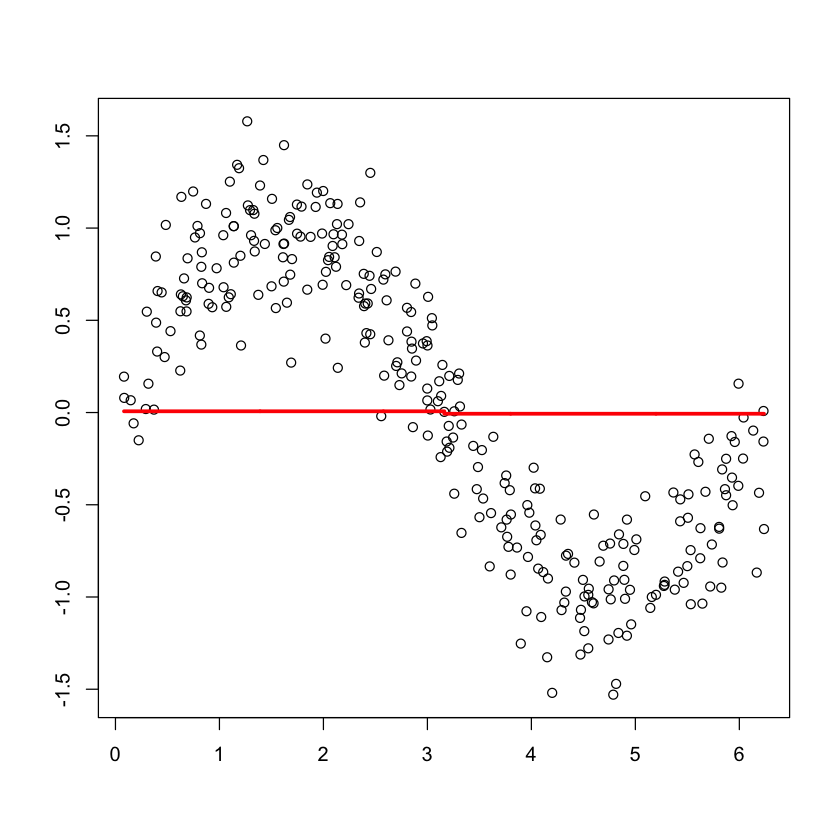

In [39]:
plot(x,y,ylab="",xlab="")
lines(x,f1,type="s",col="red",lwd=3)

- Actualizamos los residuales
  \begin{align}
  r_i\leftarrow r_i-\lambda\hat{f}^m(x)
  \end{align}

In [40]:
r1<- r - lambda*yhat1

El loop vuelve a iniciar, en la iteración 2:

In [41]:
# iteracion 2

fit2<-rpart(r1 ~ x, control = list(maxdepth = d))
yhat2<-predict(fit2,newdata=data.frame(x))
f2<- f1 + lambda *yhat2

head(lambda *yhat2)

1           2           3           4           5           6 
0.006735368 0.006735368 0.006735368 0.006735368 0.006735368 0.006735368

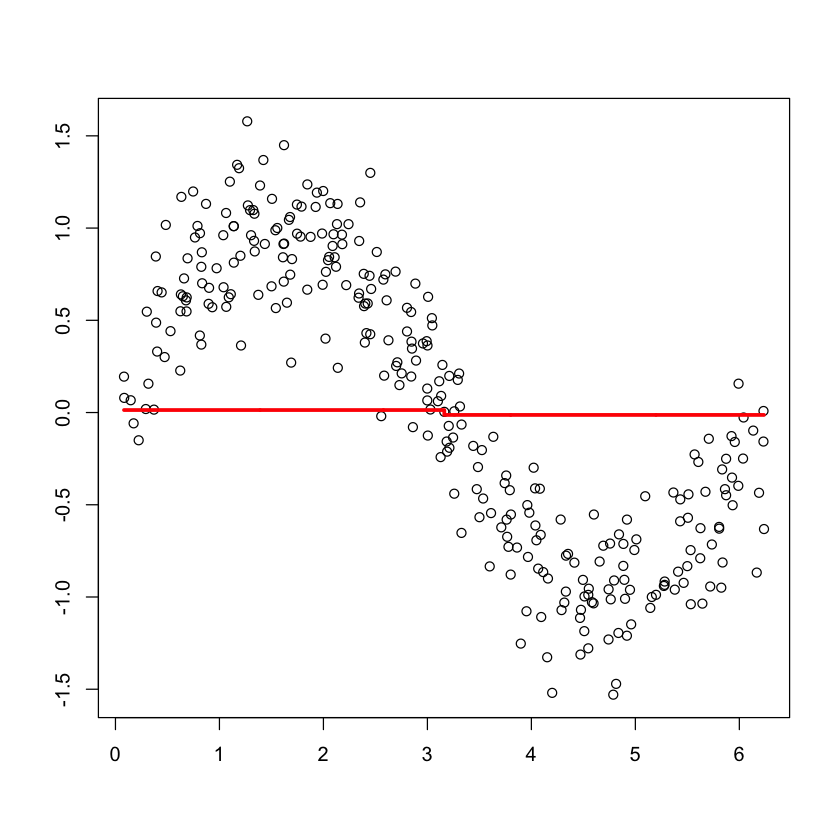

In [42]:
plot(x,y,ylab="",xlab="")
lines(x,f2,type="s",col="red",lwd=3)

In [43]:
head(f2)

1          2          3          4          5          6 
0.01353877 0.01353877 0.01353877 0.01353877 0.01353877 0.01353877

In [44]:
# En un loop
fhat<-rep(0,length(y))

r = y

YP<-lambda*fhat

for(t in 1:500){
  fit <- rpart(r~x, control = list(maxdepth = 1))
  yhat<- predict(fit,newdata=data.frame(x))
  r <-  r - lambda*yhat
  YP <-  cbind(YP,lambda*yhat)}

head(YP)

,YP,,,,,,,,,,...,,,,,,,,,,
1,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,...,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906
2,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,...,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906
3,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,...,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906
4,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,...,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906
5,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,...,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906
6,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,...,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906


In [45]:
sum(YP[1,c(1,2,3)])

[1] 0.01353877

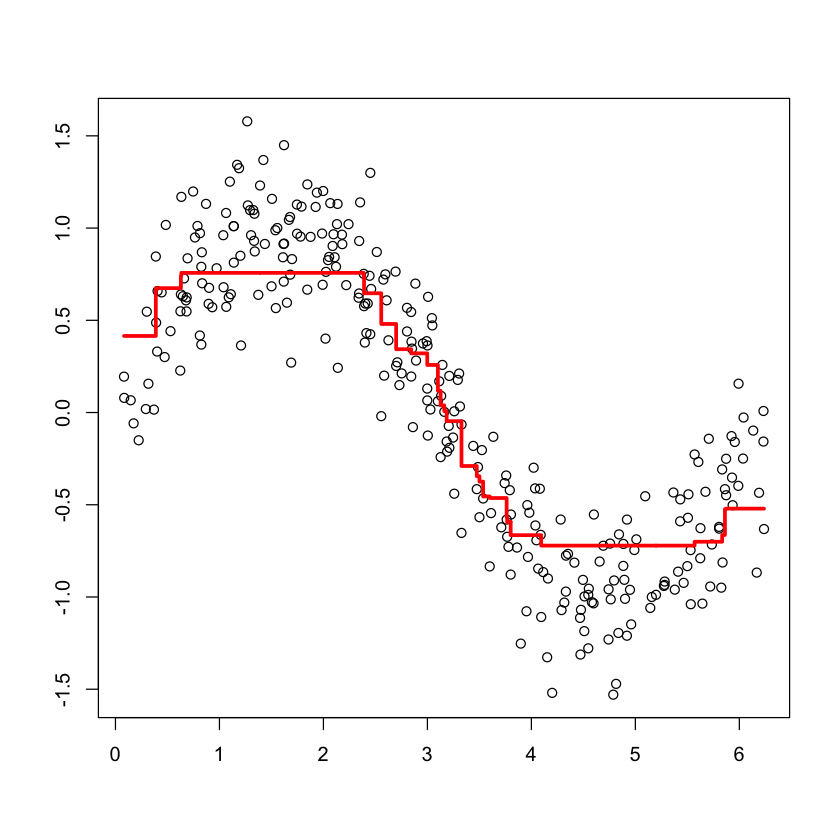

In [46]:
M<-500

fhat<-apply(YP[,1:M],1,sum)

plot(x,y,ylab="",xlab="")
lines(x,fhat,type="s",col="red",lwd=3)

### Con Caret

In [47]:
set.seed(123)
p_load("bst")

tree_boosted <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence,
    data=ames,
    method = "bstTree",
    trControl = fitControl,
    tuneGrid=expand.grid(
              mstop = c(400,500,600), #Boosting Iterations (M)
              maxdepth = c(1,2,3), # Max Tree Depth (d)
              nu = c(0.01,0.001)) # Shrinkage (lambda)
)

In [48]:
tree_boosted

Boosted Tree 

2063 samples
   3 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1651, 1651, 1650, 1651, 1649 
Resampling results across tuning parameters:

  maxdepth  nu     mstop  RMSE       Rsquared   MAE      
  1         0.001  400    0.3365268  0.3842281  0.2499121
  1         0.001  500    0.3303502  0.3945077  0.2440338
  1         0.001  600    0.3248205  0.4026357  0.2387337
  1         0.010  400    0.2687821  0.5071075  0.1938301
  1         0.010  500    0.2638835  0.5212178  0.1905012
  1         0.010  600    0.2601117  0.5315130  0.1879320
  2         0.001  400    0.3239428  0.4734204  0.2408090
  2         0.001  500    0.3155051  0.4791934  0.2327126
  2         0.001  600    0.3081800  0.4834667  0.2257991
  2         0.010  400    0.2480594  0.5676440  0.1795798
  2         0.010  500    0.2453235  0.5737810  0.1778800
  2         0.010  600    0.2437403  0.5770742  0.1769304
  3         0.001  400    0.3170812  0.523913